# Part I: Pulse Rate Algorithm


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from copy import deepcopy

import scipy as sp
import numpy as np

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
from utils import *

In [5]:
fs: int = 125
passband: Tuple[float, float] = (40 / 60, 240 / 60)  # 40-240BPM
data_root: Path = Path("../data")

---
## 1. Exploratory Data Analysis (EDA)

Load and explore one sample of the troika dataset.

In [6]:
signal_files, ref_files = get_troika_files(data_root.joinpath("troika"))
ppg, acc_x, acc_y, acc_z = load_troika_file(signal_files[0])
acc_m = np.sqrt(np.sum(np.square(np.vstack((acc_x, acc_y, acc_z))), axis=0))
bpm_true = sp.io.loadmat(ref_files[0])["BPM0"][..., 0]

### 1.1. Plot signals (before bandpass filtering)

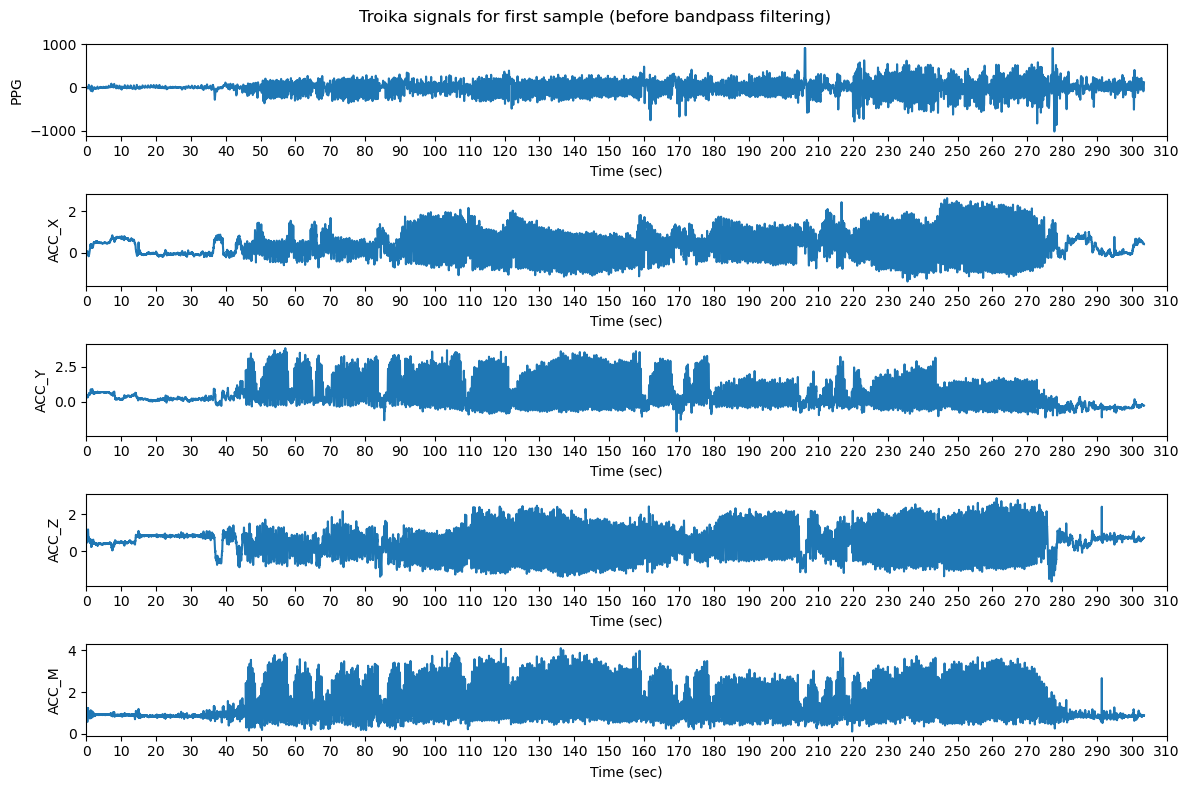

In [7]:
ts = np.arange(len(ppg)) / fs
fig, axs = plt.subplots(5, figsize=(12, 8))
fig.suptitle("Troika signals for first sample (before bandpass filtering)")

for ax, sig_data, sig_name in zip(
    axs,
    (ppg, acc_x, acc_y, acc_z, acc_m),
    ("ppg", "acc_x", "acc_y", "acc_z", "acc_m"),
):
    # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=10.0))
    ax.plot(ts, sig_data)
    ax.set(xlabel="Time (sec)", ylabel=sig_name.upper(), xlim=(0, 310))
plt.tight_layout()

The plot above clearly shows an increase in activity at around 45 seconds, and a decrease in activity at around 280 seconds.

### 1.2. Plot signals (after bandpass filtering)

In [8]:
ppg_filt, acc_x_filt, acc_y_filt, acc_z_filt, acc_m_filt = [
    bandpass_filter(sig_data, passband, fs)
    for sig_data in (ppg, acc_x, acc_y, acc_z, acc_m)
]

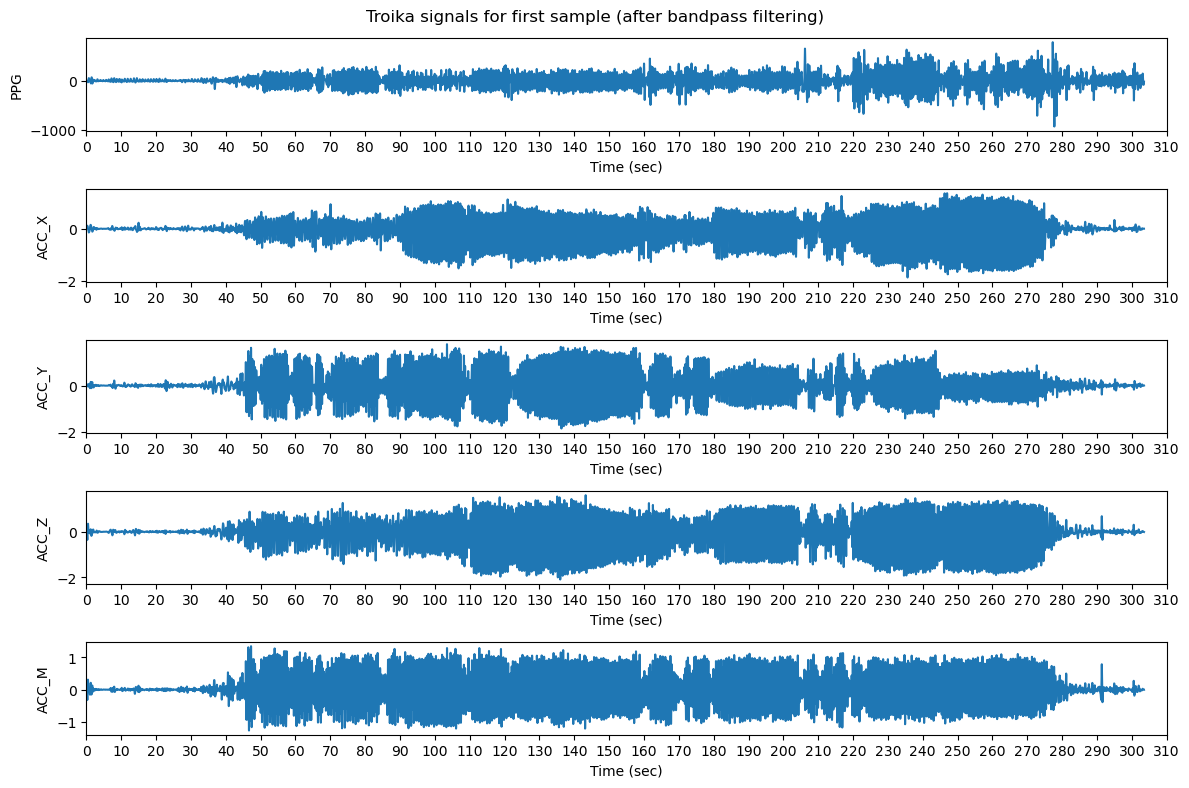

In [9]:
ts = np.arange(len(ppg)) / fs
fig, axs = plt.subplots(5, figsize=(12, 8))
fig.suptitle("Troika signals for first sample (after bandpass filtering)")

for ax, sig_data, sig_name in zip(
    axs,
    (ppg_filt, acc_x_filt, acc_y_filt, acc_z_filt, acc_m_filt),
    ("ppg", "acc_x", "acc_y", "acc_z", "acc_m"),
):
    # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=10.0))
    ax.plot(ts, sig_data)
    ax.set(xlabel="Time (sec)", ylabel=sig_name.upper(), xlim=(0, 310))
plt.tight_layout()

It is apparent that signals are considerable less noisy after our bandpass filtering!

### 1.3. Plot PPG Spectrogram

The spectrogram shows 8-second windows with 4-second overlaps.

(501, 148) (501,)


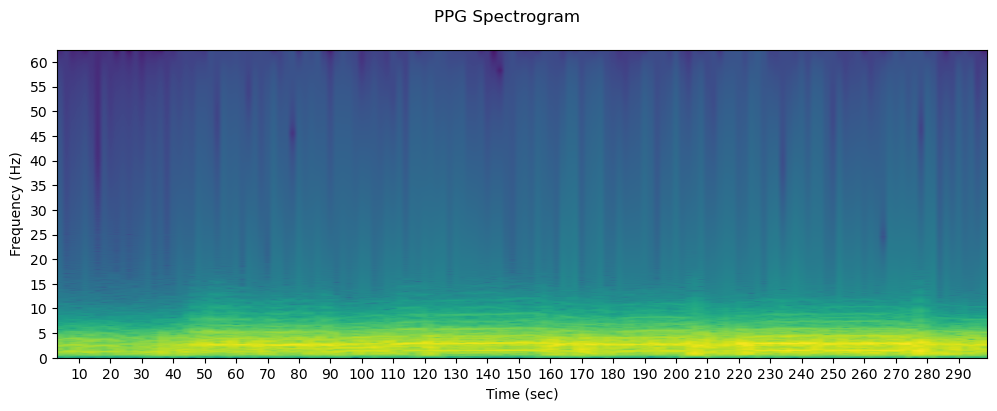

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 4))
fig.suptitle("PPG Spectrogram")

ppg_spec, ppg_freqs, _, _ = plt.specgram(ppg_filt, Fs=fs, NFFT=8 * fs, noverlap=6 * fs)

ax.xaxis.set_major_locator(plticker.MultipleLocator(base=10.0))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=5.0))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

print(ppg_spec.shape, ppg_freqs.shape)

### 1.4. Plot Accelerometer Magnitude Spectrogram

The spectrogram shows 8-second windows with 4-second overlaps.

(501, 148) (501,)


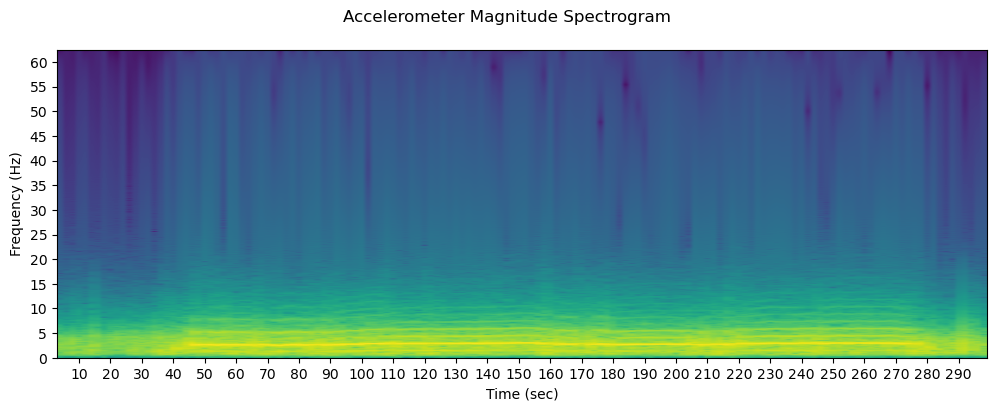

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 4))
fig.suptitle("Accelerometer Magnitude Spectrogram")

acc_m_spec, acc_m_freqs, _, _ = plt.specgram(
    acc_m_filt, Fs=fs, NFFT=8 * fs, noverlap=6 * fs
)

ax.xaxis.set_major_locator(plticker.MultipleLocator(base=10.0))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=5.0))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

print(acc_m_spec.shape, acc_m_freqs.shape)

### 1.5. Overlap of maximum frequencies per window


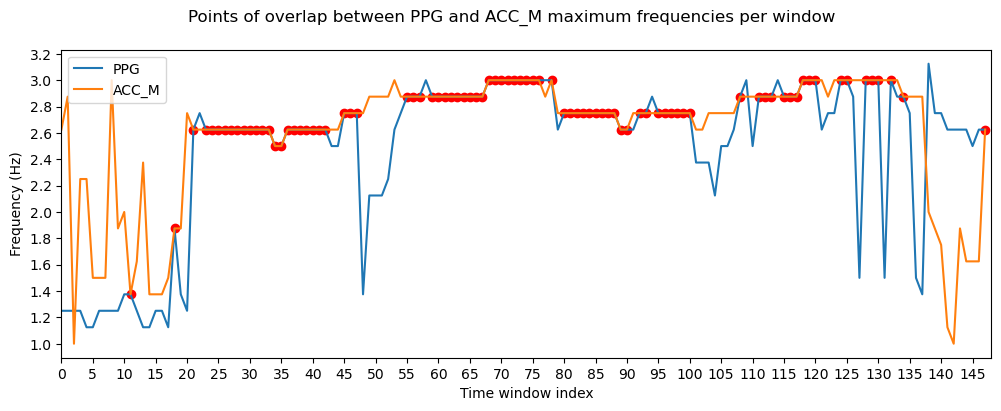

In [12]:
fig, ax = plt.subplots(1, figsize=(12, 4))
fig.suptitle("Points of overlap between PPG and ACC_M maximum frequencies per window")

ppg_spec_max_freq = ppg_freqs[np.argmax(ppg_spec, axis=0)]
plt.plot(ppg_spec_max_freq, label="PPG")

acc_m_max_freq = acc_m_freqs[np.argmax(acc_m_spec, axis=0)]
plt.plot(acc_m_max_freq, label="ACC_M")

overlap = ppg_spec_max_freq == acc_m_max_freq
plt.scatter(np.arange(len(acc_m_max_freq))[overlap], acc_m_max_freq[overlap], c="r")

ax.xaxis.set_major_locator(plticker.MultipleLocator(base=5.0))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.2))
plt.xlabel("Time window index")
plt.ylabel("Frequency (Hz)")
plt.xlim(0, ppg_spec.shape[1])
plt.legend(loc="upper left")

The plot above shows many overlaps between the PPG and ACC signals. We will need to evaluate whethere a better pulse rate estimate can be found in the PPG signal. If not found, we will have to stick with the overlapping signal.

---
## 2. Pulse Rate Estimation Evaluation

Evaluate the pulse rate estimation algorithm on the available training data.

In [13]:
evaluate()

7.6378659390743975

---
## 3. Conclusions and Project Write-up

### 3.1. Code Description

All code is contained in `src/utils.py`. The main functions are the following:

1. `run_pulse_rate_estimation()`: Run the pulse rate estimation algorithm for the given data and reference files.
2. `evaluate()`: Evaluate the pulse rate estimation algorithm on the [troika dataset](https://arxiv.org/abs/1409.5181).

### 3.2. Data Description

(Adapted from original authors)

Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously  recorded  from  subjects  with  age  from  18  to  35.  For  each  subject,  the  PPG  signals were  recorded  from  wrist  by  two  pulse  oximeters  with  green  LEDs  (wavelength:  515nm).  Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis  accelerometer.  Both  the  pulse  oximeter  and  the  accelerometer  were  embedded  in  a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using  wet  ECG  sensors.  All  signals  were  sampled  at  125  Hz  and  sent  to  a  nearby  computer  via Bluetooth.

Each dataset with the similar name 'DATA_01_TYPE01' contains a variable 'sig'. It has 6 rows. The first row  is  a  simultaneous  recording  of  ECG,  which  is  recorded  from  the  chest  of  each  subject.  The second  row  and  the  third  row  are  two  channels  of  PPG,  which  are  recorded  from  the  wrist  of  each subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis).

For convenience, we also provide the calculated ground-truth heart rate, stored in the datasets with the corresponding name, say 'REF_01_TYPE01'. In each of this kind of datasets, there is a variable 'BPM0', which  gives  the  BPM  value  in  every  8-second  time  window.  Note  that  two  successive  time  windows overlap  by  6  seconds. Thus  the  first  value  in  'BPM0'  gives  the  calcualted  heart  rate  ground-truth  in the  first  8  seconds,  while  the  second  value  in  'BPM0'  gives  the  calculated  heart  rate  ground-truth from the 3rd second to the 10th second.

### 3.3. Algorithm Description

The algorithm uses the PPG and Accelerometer signals to estimate the pulse rate at each 2 second interval. It follows these steps:

1. Bandpass filter the signals to be between 40 and 240 BPM.
2. Compute spectrograms of all signals with a window size of 8 and overlap of 6.
3. Obtain the dominant frequency components of all signals at each window.
4. Select the top K (configurable hyper-parameter, default 7) dominant frequencies in the PPG signal and discard those equal to the accelerometer signals.
5. The final pulse rate estimate will be the frequency that is closest to the estimate of the previous window.

While the PPG signal measures blood flow and thus is indicative of the heart rate, it can be affected by the movement of the finger or the arm. Therefore, we use the accelerometer information to discard similar frequencies in the PPG signal that are likely due to movement instead of blood flow.

The current algorithm uses the previous estimates to inform the next estimates. So if the first estimates are very far off, it can introduce accumulative errors that are difficult or impossible to recover from. Here we also assume that heart rate changes slowly and not suddenly. If we had to work with wider windows, this assumption could no longer hold, especially if the wearer is able to perform many different activities inside said time window.

### 3.4. Algorithm Performance

The algorithm performance was measured by first calculating the mean absolute error (MAE) between the estimates and the ground truth, as well as a confidence score. The confidence score was the ratio of the sum of the frequency spectrum near the pulse rate estimate divided by the sum of the entire spectrum.

The final performance was obtained by averaging the top 90% prediction errors with the highest confidence.

This algorithm was only tested in a few samples, which all underwent a similar activity schedule. To truly test the performance of this algorithm, we would need a much bigger dataset to get a sense of its generalization capability.